In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Recommendation systems: Deep Model

This model is made up of feature layers that have users, movies and movie genres embedings followed by a neural network with dense layers and finally one output that is the rating prediction that input user(id) could assign to input movie(id).

**Inputs**
* **User id**: Really this is traducet as a sequence because embedding layers only can manage sequenced identifiers.
* **Movie id**: Idem to User id.
* **Movie genres**: One column by genre.

**Output**
*  **Rating prediction** that user could assign to movie.

**Links**
* [Deep Learning With Keras: Recommender Systems](https://www.johnwittenauer.net/deep-learning-with-keras-recommender-systems/)
* [Collaborative Filtering for Movie Recommendations](https://keras.io/examples/structured_data/collaborative_filtering_movielens/)
* [Movie lens datasets](https://grouplens.org/datasets/movielens/)
* [Recommendation Systems Benchmarks](https://paperswithcode.com/task/recommendation-systems)

## Required libraries

In [2]:
import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import tensorflow as tf

from util import tf_detected_devices, tf_version, plot_model, Config, LoggerFactory, create_path
from callback import MetricsPlotter
from data import DataFrameDataGenerator
from recommendation import UserMovieGenderEmbeddingDenseModelFactory
from spark import SparkSessionFactory, read_csv, column_values, train_test_split, PageSet, get_columns, get_rows

import pyspark.sql.types as t
import pyspark.sql as s
import pyspark.sql.functions as f

## Logger config

In [3]:
config = Config(path='../config/config.yaml')
LoggerFactory(config['logger']).create()

<RootLogger root (INFO)>

## Config parameters

Setup test_mode variable to enable or disable model train before check their prediction precision:

In [4]:
train_model = True

## Check environment

**Step 1**: Make sure that nvidia driver is installed runing next command:

In [5]:
!nvidia-smi --query-gpu=gpu_name,memory.total --format=csv | sed -n 2p

GeForce RTX 3080, 10015 MiB


**Note:** If this shows a GPU model and memory size, that's all right, otherwise make suze that has the nvidia driver installed.

**Step 2**: Let's check tensorflow version:

In [6]:
tf_version()

'Tensorflow version: 2.5.0-dev20201229'

**Step 3**: Let's check devices that tensorflow detect:

In [7]:
tf_detected_devices()

,Name,Device Type,Memory,Description
0,/device:CPU:0,CPU,256M,


In [8]:
tf.debugging.set_log_device_placement(False)

**Step 4**: Make sure that tensorflow detect cuda libs and GPU devices.

In [9]:
tf.test.is_built_with_cuda()

True

In [10]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Prepare model input data

**Step 1**: Create a predefined spark session. this is used to create a pipeline that build the model input features. 

In [11]:
session = SparkSessionFactory.create()
session

**Note**: When create a spark session this run a new spark cluster with one instance in localhost. You can monitor instance jobs clicking the **Spark UI** link. 

**Step 2**: Load raw dataset to a spark dataset. 

In [12]:
TEMP_PATH = './temp'
TRAIN_PATH = f'{TEMP_PATH}/train'
VAL_PATH = f'{TEMP_PATH}/val'
TEST_PATH = f'{TEMP_PATH}/test'

In [13]:
train_set = read_csv(session, f'{TRAIN_PATH}/*.csv')

In [14]:
val_set = read_csv(session, f'{VAL_PATH}/*.csv')

In [15]:
test_set = read_csv(session, f'{TEST_PATH}/*.csv')

In [16]:
print(f'Train set size: {"{:,}".format(train_set.count())} samples.')
print(f'Validation set size: {"{:,}".format(val_set.count())} samples.')

Train set size: 17,499,608 samples.
Validation set size: 6,750,448 samples.


**Step 3:** Let's see min and max value of rating column.

In [17]:
min_max = train_set.agg(f.min('rating'), f.max('rating')).collect()[0]
min_rating, max_rating = min_max[0], min_max[1]

print('Ratting - min: ', min_rating, 'max:', max_rating)

Ratting - min:  0.5 max: 5.0


**Step 4:** Let's see all dataset columns.

In [18]:
class ColumnService:
    def __init__(self, columns):
        excluded_columns = ['user_id', 'movie_id']
        self.labels = ['rating']

        self.features = list(set(columns) - set(self.labels) - set(excluded_columns))
        self.features = sorted(self.features, key=lambda x: 'gen_' in x)

        self.gender_features = [c for c in self.features if 'gen_' in c]
        self.emb_features = [c for c in self.features if '_seq' in c]
        self.emb_features = sorted(self.emb_features, key=lambda x: 'user' in x, reverse=True)

column_manager = ColumnService(train_set.columns)

**Step 5**: Calculate train, val batch_size and plot interval.

In [19]:
import math

steps  = 120
epochs = 1
plot_interval = math.floor(steps / 10)

train_batch_size        = math.floor(train_set.count() / steps)
val_batch_size    = math.floor(val_set.count() / steps)
evaluate_interval = plot_interval + 1

In [20]:
print(f'Train Batch Size      : {"{:,}".format(train_batch_size)}.')
print(f'Validation Batch Size : {"{:,}".format(val_batch_size)}.')
print('Plot Interval         :', plot_interval)
print('Evaluate Interval     :', evaluate_interval)
print('Epochs                :', epochs)

Train Batch Size      : 145,830.
Validation Batch Size : 56,253.
Plot Interval         : 12
Evaluate Interval     : 13
Epochs                : 1


In [21]:
class RecommendationsDataGenerator(DataFrameDataGenerator):    
    def _features(self, page, columns):
        emb1 = get_rows(page, column_manager.emb_features[0])
        emb2 = get_rows(page, column_manager.emb_features[1])
        genders = get_rows(page, column_manager.gender_features)
        return [emb1, emb2, genders]

In [22]:
train_generator = RecommendationsDataGenerator(
    train_set, 
    column_manager.features,
    column_manager.labels,
    train_batch_size, 
    shuffle=True,
    name='train'
)

INFO 2021-01-04 19:48:15 - page-set-140231425442384 - Page Size: 145830
INFO 2021-01-04 19:48:15 - page-set-140231425442384 - Pages Count: 121
INFO 2021-01-04 19:48:15 - page-set-140231425442384 - Total elements: 17499608


In [23]:
val_generator = RecommendationsDataGenerator(
    val_set,
    column_manager.features,
    column_manager.labels,
    val_batch_size,
    shuffle=False,
    name='val'
)

INFO 2021-01-04 19:48:16 - page-set-140231425182448 - Page Size: 56253
INFO 2021-01-04 19:48:16 - page-set-140231425182448 - Pages Count: 121
INFO 2021-01-04 19:48:16 - page-set-140231425182448 - Total elements: 6750448


In [24]:
n_users = train_set.select('user_seq') \
            .union(val_set.select('user_seq')) \
            .union(test_set.select('user_seq')) \
            .distinct() \
            .count()

n_movies = train_set.select('movie_seq') \
            .union(val_set.select('movie_seq')) \
            .union(test_set.select('movie_seq')) \
            .distinct() \
            .count()

print(f'Train set size: {"{:,}".format(n_users)}.')
print(f'Validation set size: {"{:,}".format(n_movies)}.')

Train set size: 56,273.
Validation set size: 10,359.


In [25]:
model = UserMovieGenderEmbeddingDenseModelFactory.create(
    n_users, 
    n_movies,
    n_genders=len(column_manager.gender_features),
    min_rating=min_rating, 
    max_rating=max_rating,
    user_n_min_factors=50,
    movie_n_min_factors=50,
    lr=0.001,
    units=[512],
    dropout=[0.5]
)

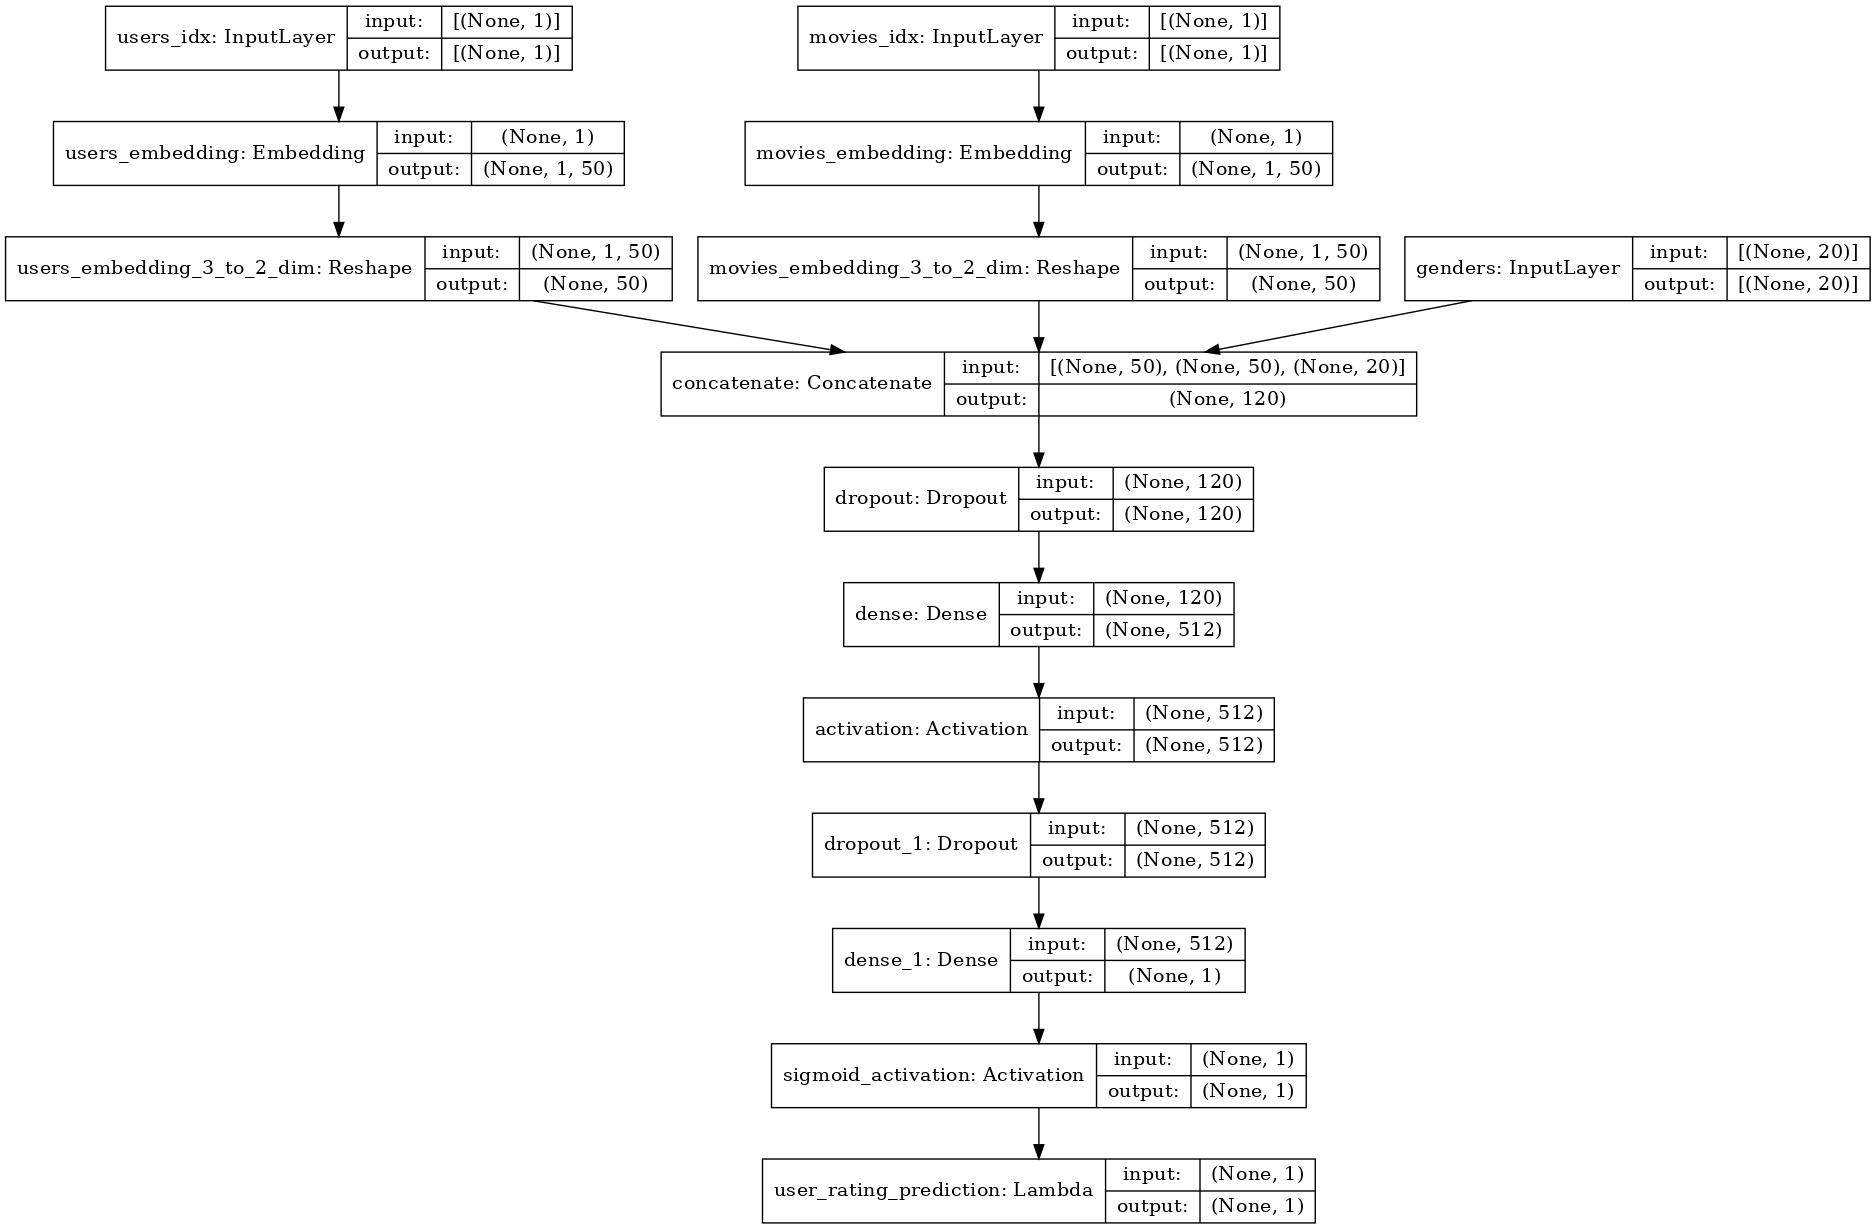

In [26]:
plot_model(model, rankdir="TB")

In [27]:
model.summary()

Model: "Embedding_Feature_Layers_Plus_Dense_Layer_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
users_idx (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
movies_idx (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
users_embedding (Embedding)     (None, 1, 50)        2813650     users_idx[0][0]                  
__________________________________________________________________________________________________
movies_embedding (Embedding)    (None, 1, 50)        517950      movies_idx[0][0]                 
____________________________________________________

In [28]:
if train_model:
    history = model.fit_generator(
        generator=train_generator,
        validation_data=val_generator,
        epochs=epochs,
        verbose=1, 
        callbacks=[
            MetricsPlotter(
                validation_generator=val_generator, 
                metrics_names=['loss'],
                plot_interval=plot_interval,
                evaluate_interval=evaluate_interval,
                batch_size=train_batch_size,
                val_batch_size=val_batch_size
            )
        ]
    )

loss
  1/121 [..............................] - ETA: 4:03:18 - loss: 2.1253

Evaluate model each 13 steps(Batch-size: 56253):
  2/121 [..............................] - ETA: 4:35:39 - loss: 1.9684

UnknownError: 2 root error(s) found.
  (0) Unknown:  Py4JJavaError: An error occurred while calling o994.javaToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 106 in stage 325.0 failed 1 times, most recent failure: Lost task 106.0 in stage 325.0 (TID 26770, skynet.local, executor driver): java.io.IOException: No space left on device
	at java.base/sun.nio.ch.FileDispatcherImpl.write0(Native Method)
	at java.base/sun.nio.ch.FileDispatcherImpl.write(FileDispatcherImpl.java:62)
	at java.base/sun.nio.ch.IOUtil.writeFromNativeBuffer(IOUtil.java:113)
	at java.base/sun.nio.ch.IOUtil.write(IOUtil.java:58)
	at java.base/sun.nio.ch.FileChannelImpl.write(FileChannelImpl.java:285)
	at java.base/sun.nio.ch.FileChannelImpl.transferToTrustedChannel(FileChannelImpl.java:593)
	at java.base/sun.nio.ch.FileChannelImpl.transferTo(FileChannelImpl.java:686)
	at org.apache.spark.util.Utils$.copyFileStreamNIO(Utils.scala:429)
	at org.apache.spark.util.Utils.copyFileStreamNIO(Utils.scala)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.writePartitionedDataWithChannel(BypassMergeSortShuffleWriter.java:232)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.writePartitionedData(BypassMergeSortShuffleWriter.java:205)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:167)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:446)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:449)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1130)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:630)
	at java.base/java.lang.Thread.run(Thread.java:832)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2008)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2007)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2007)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:973)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:973)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:973)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2239)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2188)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2177)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:775)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2099)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2120)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2139)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2164)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1004)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1003)
	at org.apache.spark.RangePartitioner$.sketch(Partitioner.scala:304)
	at org.apache.spark.RangePartitioner.<init>(Partitioner.scala:171)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$.prepareShuffleDependency(ShuffleExchangeExec.scala:255)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.shuffleDependency$lzycompute(ShuffleExchangeExec.scala:143)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.shuffleDependency(ShuffleExchangeExec.scala:137)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.$anonfun$doExecute$1(ShuffleExchangeExec.scala:154)
	at org.apache.spark.sql.catalyst.errors.package$.attachTree(package.scala:52)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.doExecute(ShuffleExchangeExec.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:175)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:213)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:210)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:171)
	at org.apache.spark.sql.execution.InputAdapter.inputRDD(WholeStageCodegenExec.scala:525)
	at org.apache.spark.sql.execution.InputRDDCodegen.inputRDDs(WholeStageCodegenExec.scala:453)
	at org.apache.spark.sql.execution.InputRDDCodegen.inputRDDs$(WholeStageCodegenExec.scala:452)
	at org.apache.spark.sql.execution.InputAdapter.inputRDDs(WholeStageCodegenExec.scala:496)
	at org.apache.spark.sql.execution.SortExec.inputRDDs(SortExec.scala:132)
	at org.apache.spark.sql.execution.ProjectExec.inputRDDs(basicPhysicalOperators.scala:47)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:720)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:175)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:213)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:210)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:171)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:122)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:121)
	at org.apache.spark.sql.Dataset.javaToPython(Dataset.scala:3441)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:64)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:564)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:832)
Caused by: java.io.IOException: No space left on device
	at java.base/sun.nio.ch.FileDispatcherImpl.write0(Native Method)
	at java.base/sun.nio.ch.FileDispatcherImpl.write(FileDispatcherImpl.java:62)
	at java.base/sun.nio.ch.IOUtil.writeFromNativeBuffer(IOUtil.java:113)
	at java.base/sun.nio.ch.IOUtil.write(IOUtil.java:58)
	at java.base/sun.nio.ch.FileChannelImpl.write(FileChannelImpl.java:285)
	at java.base/sun.nio.ch.FileChannelImpl.transferToTrustedChannel(FileChannelImpl.java:593)
	at java.base/sun.nio.ch.FileChannelImpl.transferTo(FileChannelImpl.java:686)
	at org.apache.spark.util.Utils$.copyFileStreamNIO(Utils.scala:429)
	at org.apache.spark.util.Utils.copyFileStreamNIO(Utils.scala)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWrit [Op:__inference_train_function_983]

Function call stack:
train_function


Check model loss after training process:

In [ ]:
def evaluate_xy_model(model, column_manager, data_frame, batch_size):
    data_generator = RecommendationsDataGenerator(
        data_frame,
        column_manager.features,
        column_manager.labels,
        data_frame.count(),
        shuffle=False
    )
    X, y = data_generator[0]
    return model.evaluate(X, y, batch_size=batch_size, verbose=0)

In [ ]:
val_loss = evaluate_xy_model(model, column_manager, val_set, val_batch_size)
val_loss

Save the weights tthat model has learned:

In [ ]:
## WEIGHTS_PATH = create_path(f'../weights')
WEIGHTS_FILE = f'{WEIGHTS_PATH}/user_movie_genders_deep_model_weights_val_loss_{val_loss}.h5'
model.save_weights(WEIGHTS_FILE)